## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.



**Цель исследования:** Разработать модель, которая предскажет вероятность снижения покупательской активности.
Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность. 


**Датафрэймы:**
1. market_file.csv

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
id — номер покупателя в корпоративной базе данных.

- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт». Зависит от наличия определенной подписки у пользователя.
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта за последние 3 месяца.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

2. market_money.csv

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период в условных единицах.

3. market_time.csv

- Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

4. money.csv

Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли в условных единицах.

## Загрузка данных

Импортируем необходимые библиотеки.

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import math

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import phik
import shap

pd.options.display.float_format = '{:,.4f}'.format

Загрузим данные и выведим их на экран.

In [3]:
try:
    market_file = pd.read_csv('market_file.csv')
except:
    market_file = pd.read_csv('/datasets/market_file.csv')
try:
    market_money = pd.read_csv('market_money.csv')
except:
    market_money = pd.read_csv('/datasets/market_money.csv')
try:
    market_time = pd.read_csv('market_time.csv')
except:
    market_time = pd.read_csv('/datasets/market_time.csv')
try:
    money = pd.read_csv('money.csv', sep=';', decimal=",")
except:
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")
    
display(market_file.head())
display(market_money.head())
display(market_time.head())
display(money.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4000,5,121,0.0000,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4000,4,819,0.7500,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9000,3,539,0.1400,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2000,5,896,0.9900,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1000,3,1064,0.9400,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0000
1,215348,текущий_месяц,"3,293.1000"
2,215348,предыдущий_месяц,0.0000
3,215349,препредыдущий_месяц,"4,472.0000"
4,215349,текущий_месяц,"4,971.6000"


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.9800
1,215349,4.1600
2,215350,3.1300
3,215351,4.8700
4,215352,4.2100


In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Предобработка данных

### Общая оценка

Проверим основную информацию по загруженным данным.

In [5]:
market_file.info()
market_file.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,"1,300.0000","1,300.0000","1,300.0000","1,300.0000","1,300.0000","1,300.0000","1,300.0000","1,300.0000","1,300.0000"
mean,"215,997.5000",4.2538,4.0115,601.8985,0.3198,3.2700,2.8400,4.1854,8.1769
std,375.4220,1.0148,0.6969,249.8563,0.2498,1.3554,1.9715,1.9553,3.9781
min,"215,348.0000",0.9000,3.0000,110.0000,0.0000,1.0000,0.0000,0.0000,1.0000
25%,"215,672.7500",3.7000,4.0000,405.5000,0.1700,2.0000,1.0000,3.0000,5.0000
50%,"215,997.5000",4.2000,4.0000,606.0000,0.2400,3.0000,3.0000,4.0000,8.0000
75%,"216,322.2500",4.9000,4.0000,806.0000,0.3000,4.0000,4.0000,6.0000,11.0000
max,"216,647.0000",6.6000,5.0000,"1,079.0000",0.9900,6.0000,10.0000,9.0000,20.0000


Столбцы датасета соответствуют описанию, пропуски отсутствуют. Однако в названиях некоторых столбцов есть пробелы, что потребует исправления в будущем. Тип данных Маркет_актив_6_мес и Акционные_покупки, не соответствует их описанию.

In [6]:
market_money.info()
market_money.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Выручка
count,"3,900.0000","3,900.0000"
mean,"215,997.5000","5,025.6961"
std,375.3257,"1,777.7041"
min,"215,348.0000",0.0000
25%,"215,672.7500","4,590.1500"
50%,"215,997.5000","4,957.5000"
75%,"216,322.2500","5,363.0000"
max,"216,647.0000","106,862.2000"


Столбцы датасета соответствуют описанию, и явных пропусков не наблюдается. Однако тип данных столбца Выручка не соответствует заявленному. Кроме того, в датасете присутствуют записи с выручкой 0 и выручкой более 100 000, что вызывает подозрения. Необходимо проверить эти данные в дальнейшем.

In [7]:
market_time.info()
market_time.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,минут
count,"2,600.0000","2,600.0000"
mean,"215,997.5000",13.3362
std,375.3498,4.0802
min,"215,348.0000",4.0000
25%,"215,672.7500",10.0000
50%,"215,997.5000",13.0000
75%,"216,322.2500",16.0000
max,"216,647.0000",23.0000


С этими данными все хорошо.

In [8]:
money.info()
money.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
count,"1,300.0000","1,300.0000"
mean,"215,997.5000",3.9966
std,375.4220,1.0137
min,"215,348.0000",0.8600
25%,"215,672.7500",3.3000
50%,"215,997.5000",4.0450
75%,"216,322.2500",4.6700
max,"216,647.0000",7.4300


С этими данными также все хорошо.

### Приступаем к работе с данными.

Сначала нужно упорядочить наименования столбцов, привести типы данных к единообразию, а также выявить пропуски, ошибки и дубликаты в содержащейся информации.

Заменим пробелы на подчеркивания.

In [9]:
market_file.columns = market_file.columns.str.replace(' ', '_').str.lower()
market_money.columns = market_money.columns.str.lower()
market_time.columns = market_time.columns.str.lower()
money.columns = money.columns.str.lower()

market_file.info()
market_money.info()
market_time.info()
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

### Удаление дупликатов

Проверим наличие дупликатов в датасетах.

In [10]:
display(market_file.duplicated().sum())
display(market_money.duplicated().sum())
display(market_time.duplicated().sum())
display(money.duplicated().sum())

0

0

0

0

Дубликаты не обнаружены.

### Обработка пропусков 

In [11]:
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [12]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [13]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [14]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

Видим, что датасеты не содержат пропусков. 

Выполнили предобработку данных: проверили данные на дупликаты и пропуски, привели названия столбцов к одному стилю.

## Исследовательский анализ данных

Проверим данные на выбросы и аномальные значения.

array(['Снизилась', 'Прежний уровень'], dtype=object)

Text(0.5, 0, 'Количество')

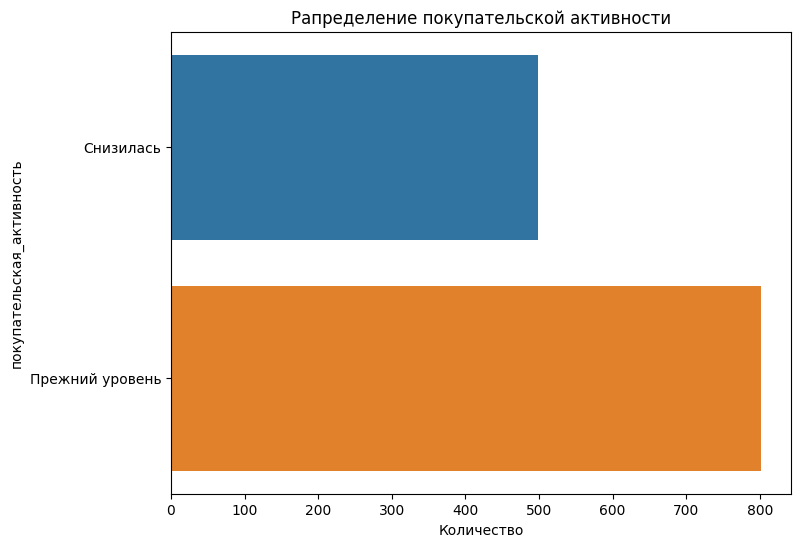

In [15]:
display(market_file['покупательская_активность'].unique()) 
plt.figure(figsize = (8,6))
plot = sns.countplot(y = 'покупательская_активность', data = market_file)
plot.set_title('Рапределение покупательской активности')
plot.set_xlabel('Количество')

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Text(0.5, 0, 'Количество')

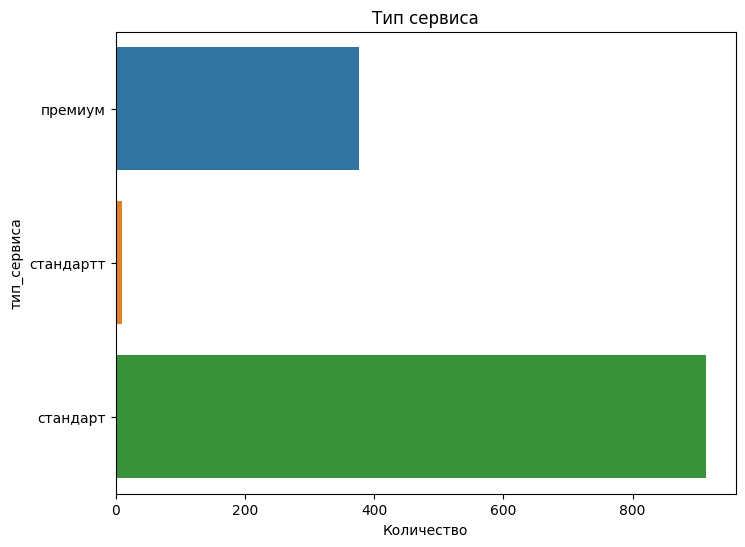

In [16]:
display(market_file['тип_сервиса'].unique())    
plt.figure(figsize = (8,6))
plot = sns.countplot(y = 'тип_сервиса', data = market_file)
plot.set_title('Тип сервиса')
plot.set_xlabel('Количество')

Обнаружилась опечатка, исправим ее.

In [17]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

array(['да', 'нет'], dtype=object)

Text(0.5, 0, 'Количество')

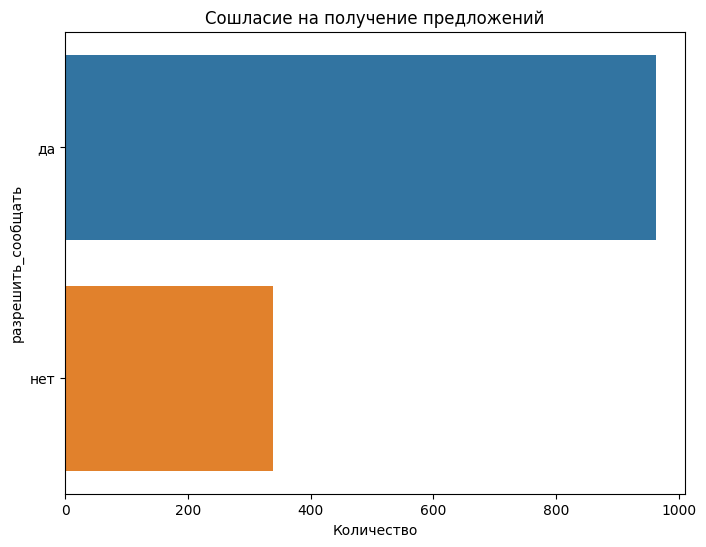

In [18]:
display(market_file['разрешить_сообщать'].unique())    
plt.figure(figsize = (8,6))
plot = sns.countplot(y = 'разрешить_сообщать', data = market_file)
plot.set_title('Сошласие на получение предложений')
plot.set_xlabel('Количество')

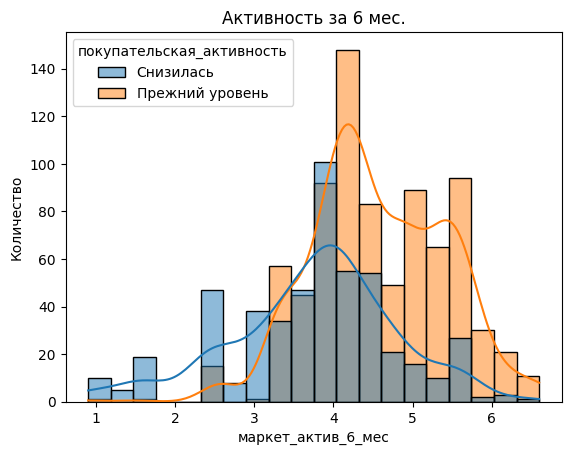

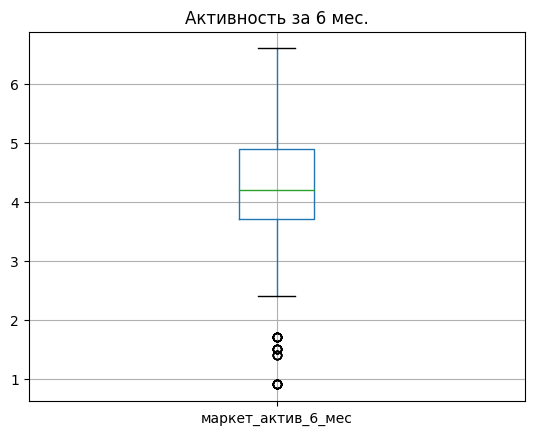

In [19]:
sns.histplot(data=market_file, x = 'маркет_актив_6_мес', hue = 'покупательская_активность', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Активность за 6 мес.')
plt.show()

market_file.boxplot(column = 'маркет_актив_6_мес')
plt.title('Активность за 6 мес.')
plt.show()

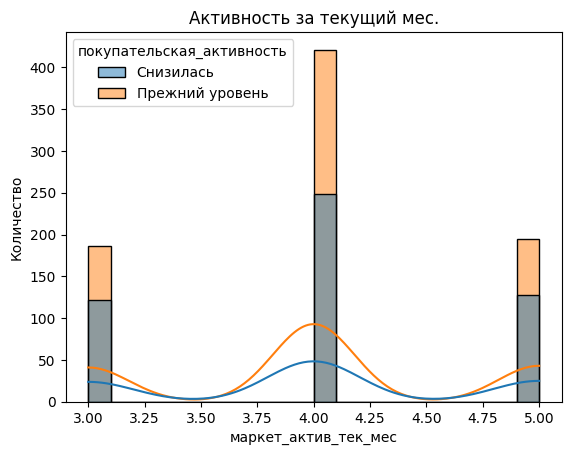

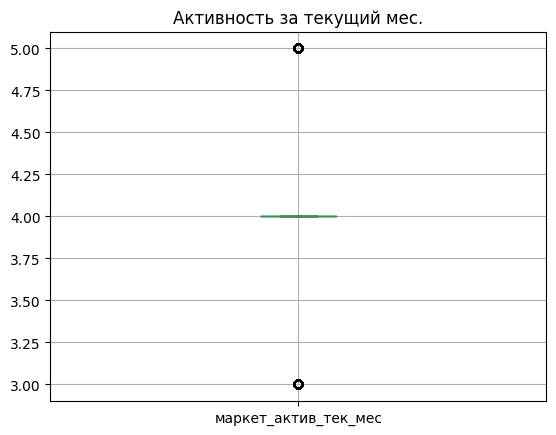

In [20]:
sns.histplot(data = market_file, x = 'маркет_актив_тек_мес', hue = 'покупательская_активность', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Активность за текущий мес.')
plt.show()

market_file.boxplot(column = 'маркет_актив_тек_мес')
plt.title('Активность за текущий мес.')
plt.show()

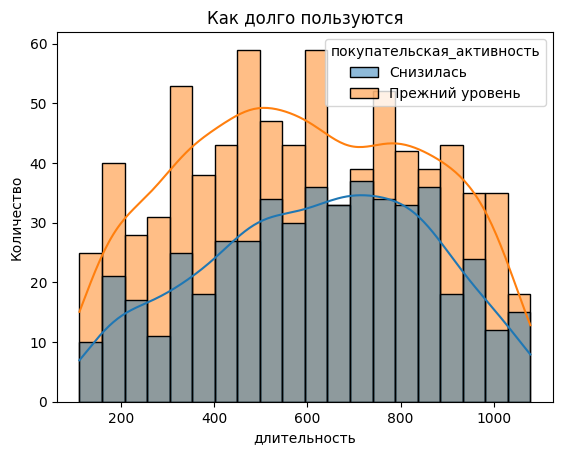

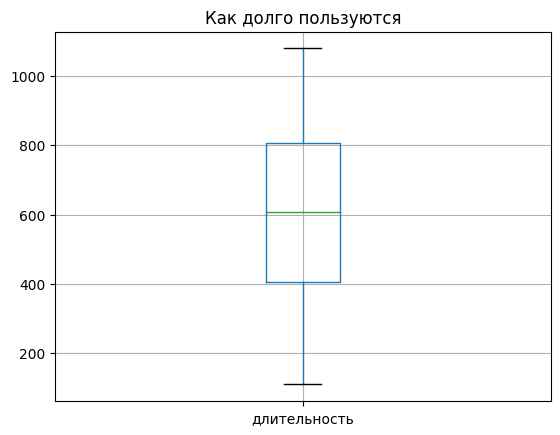

In [21]:
sns.histplot(data = market_file, x = 'длительность', hue = 'покупательская_активность', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Как долго пользуются')
plt.show()

market_file.boxplot(column = 'длительность')
plt.title('Как долго пользуются')
plt.show()

Все выглядит хорошо.

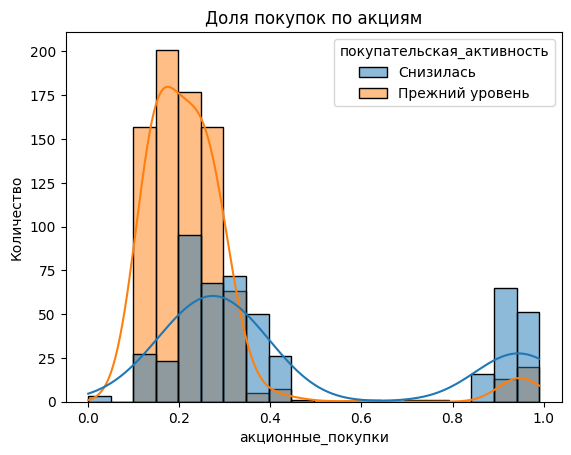

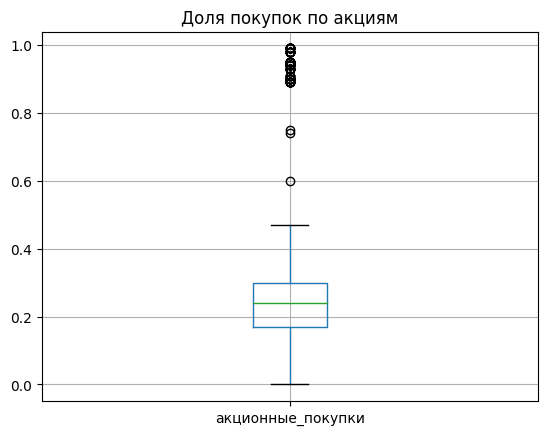

In [22]:
sns.histplot(data = market_file, x = 'акционные_покупки', hue = 'покупательская_активность', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Доля покупок по акциям')
plt.show()

market_file.boxplot(column = 'акционные_покупки')
plt.title('Доля покупок по акциям')
plt.show()

Основная часть людей покупает продукцию в основном без акций, но так же есть группа людей, которая покупает в основном акционную продукцию. Учтем это при дальнейшей работе.

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Text(0.5, 0, 'Количество')

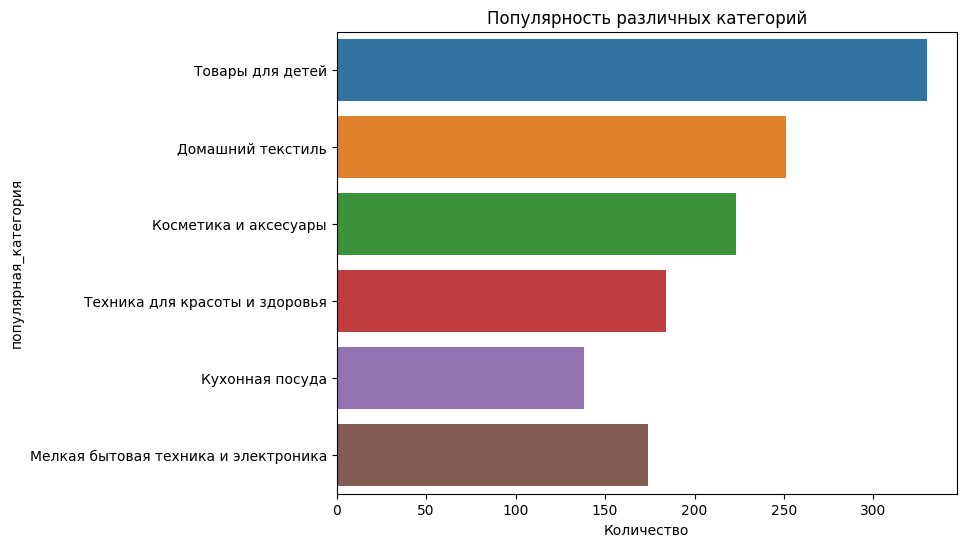

In [23]:
display(market_file['популярная_категория'].unique()) 
plt.figure(figsize = (8,6))
plot = sns.countplot(y = 'популярная_категория', data = market_file)
plot.set_title('Популярность различных категорий')
plot.set_xlabel('Количество')

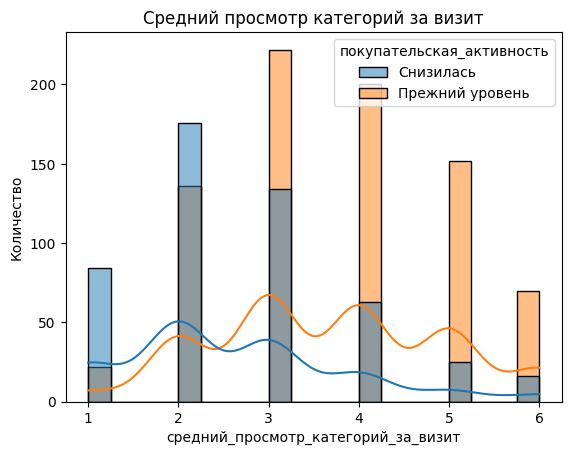

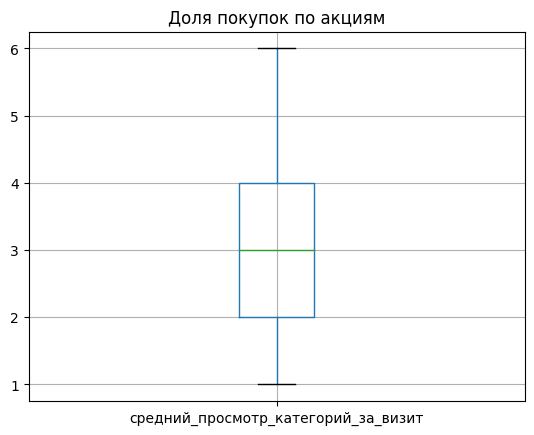

In [24]:
sns.histplot(data = market_file, x = 'средний_просмотр_категорий_за_визит', hue = 'покупательская_активность', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Средний просмотр категорий за визит')
plt.show()

market_file.boxplot(column = 'средний_просмотр_категорий_за_визит')
plt.title('Доля покупок по акциям')
plt.show()

Все выглядит хорошо.

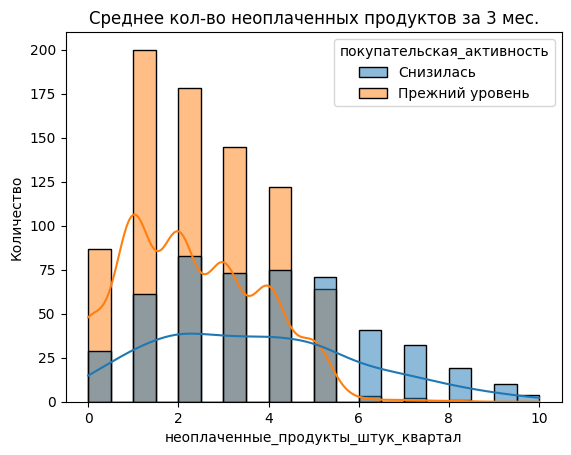

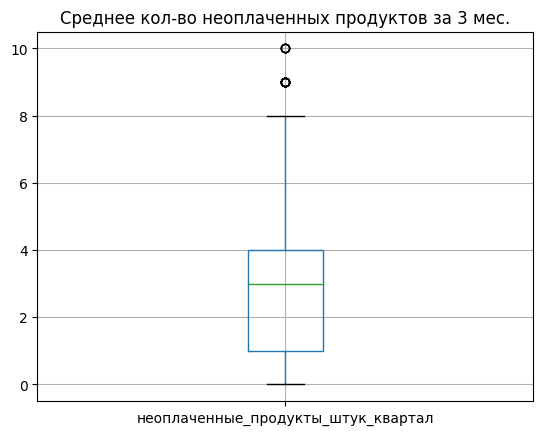

In [25]:
sns.histplot(data = market_file, x = 'неоплаченные_продукты_штук_квартал', hue = 'покупательская_активность', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Среднее кол-во неоплаченных продуктов за 3 мес.')
plt.show()

market_file.boxplot(column = 'неоплаченные_продукты_штук_квартал')
plt.title('Среднее кол-во неоплаченных продуктов за 3 мес.')
plt.show()

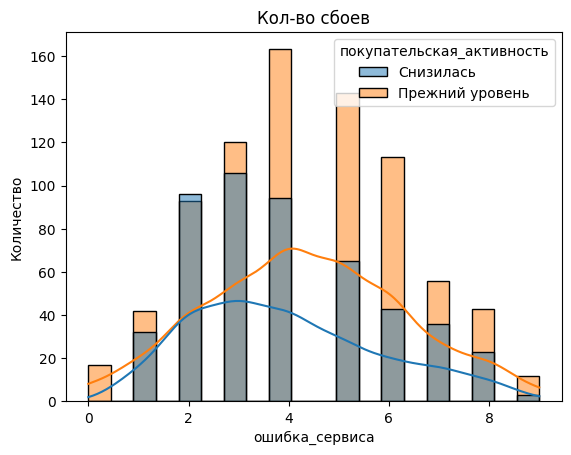

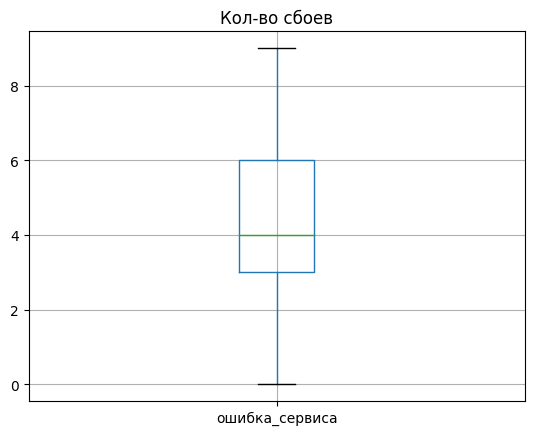

In [26]:
sns.histplot(data = market_file, x = 'ошибка_сервиса', hue = 'покупательская_активность', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Кол-во сбоев')
plt.show()

market_file.boxplot(column = 'ошибка_сервиса')
plt.title('Кол-во сбоев')
plt.show()

Многовато сбоев.

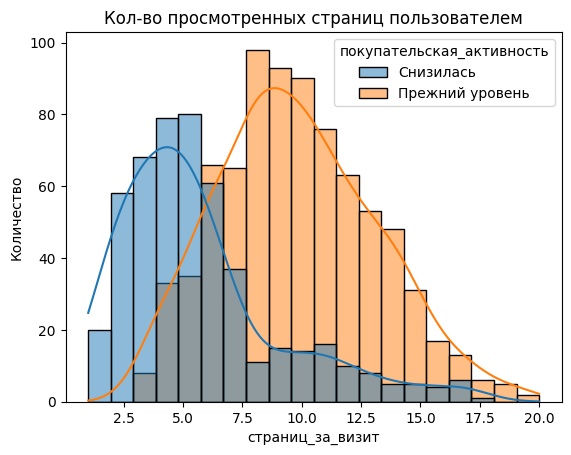

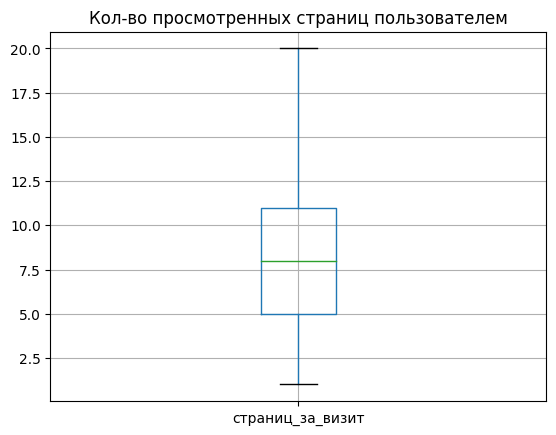

In [27]:
sns.histplot(data = market_file, x = 'страниц_за_визит', hue = 'покупательская_активность', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Кол-во просмотренных страниц пользователем')
plt.show()

market_file.boxplot(column = 'страниц_за_визит')
plt.title('Кол-во просмотренных страниц пользователем')
plt.show()

Все выглядит хорошо.

Следущая таблица - **market_money**

In [28]:
market_money_period = market_money.pivot_table(index='период', values=['выручка'], aggfunc='sum')
market_money_period

,выручка
период,
предыдущий_месяц,"6,417,996.5000"
препредыдущий_месяц,"6,272,769.0000"
текущий_месяц,"6,909,449.1000"


Text(0.5, 0, 'Количество')

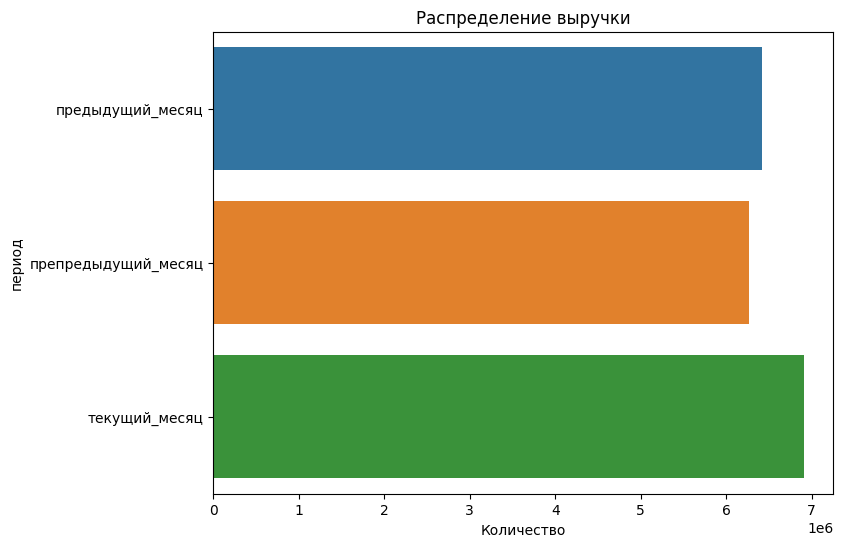

In [29]:
plt.figure(figsize=(8,6))
plot = sns.barplot(x='выручка', data=market_money_period, y=market_money_period.index)
plot.set_title('Распределение выручки')
plot.set_xlabel('Количество')

Ого прямо ровно ровно.

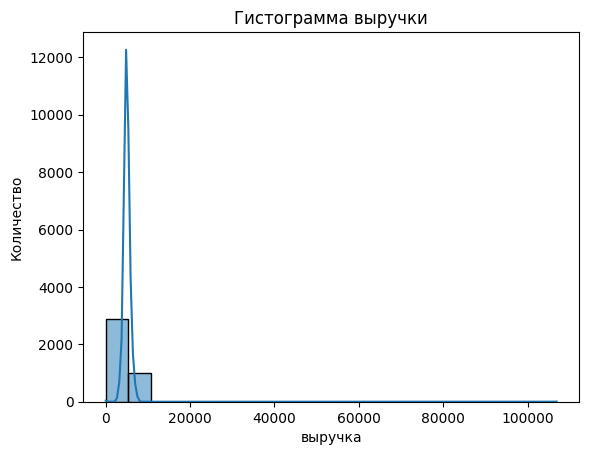

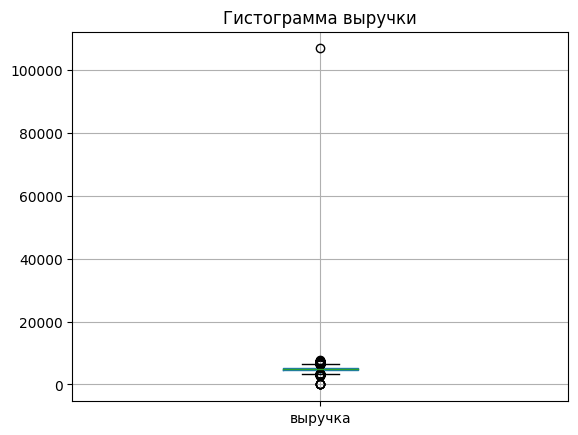

In [30]:
sns.histplot(data = market_money, x = 'выручка', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Гистограмма выручки')
plt.show()

market_money.boxplot(column = 'выручка')
plt.title('Гистограмма выручки')
plt.show()

In [31]:
market_money.query('выручка > 100000')

,id,период,выручка
98,215380,текущий_месяц,"106,862.2000"


Явно выброс, от которого стоит избавиться.

In [32]:
market_money.drop(98, inplace = True)

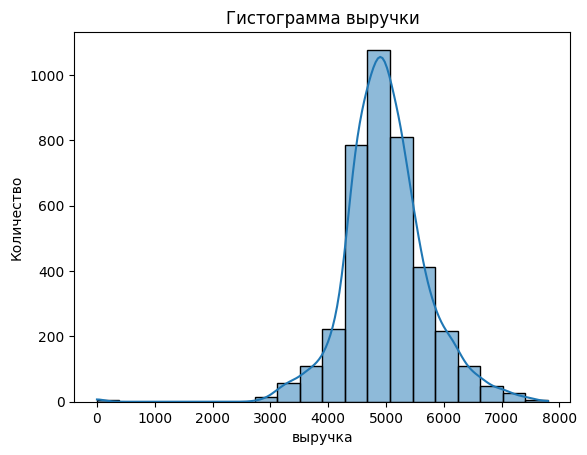

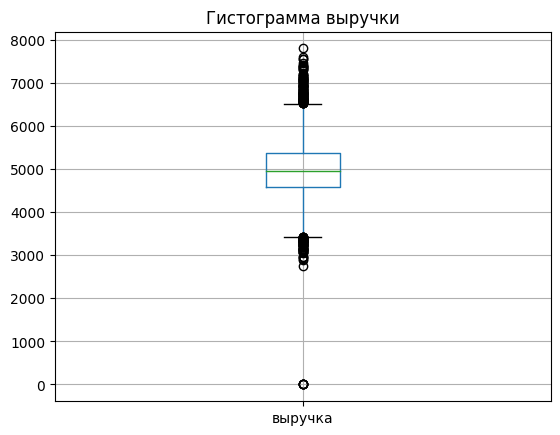

In [33]:
sns.histplot(data = market_money, x = 'выручка', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Гистограмма выручки')
plt.show()

market_money.boxplot(column = 'выручка')
plt.title('Гистограмма выручки')
plt.show()

In [34]:
market_money.query('выручка < 1')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0000
2,215348,предыдущий_месяц,0.0000
28,215357,препредыдущий_месяц,0.0000
29,215357,предыдущий_месяц,0.0000
34,215359,предыдущий_месяц,0.0000
35,215359,препредыдущий_месяц,0.0000


Периодов, в которые не было выручки. Эти данные нежелательны, так как мы планируем в дальнейшем работать только с пользователями, проявляющими активность в течение трёх месяцев. Наличие таких пустых записей будет нам мешать.

In [35]:
market_money = market_money[market_money['выручка'] > 0]

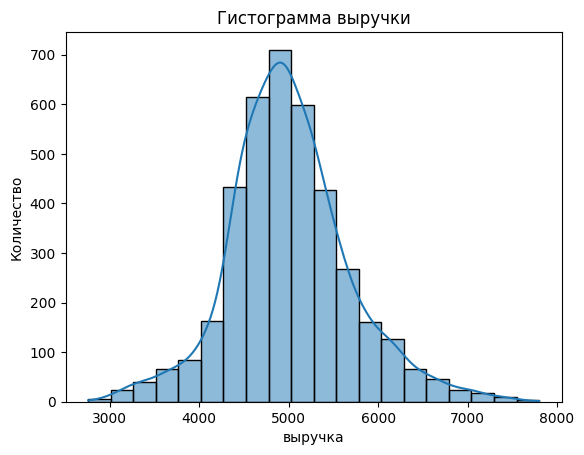

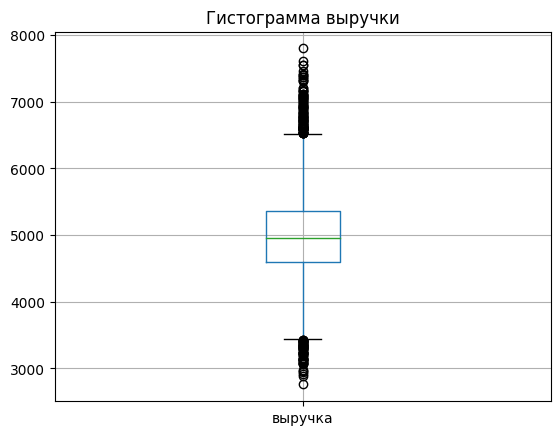

In [36]:
sns.histplot(data = market_money, x = 'выручка', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Гистограмма выручки')
plt.show()

market_money.boxplot(column = 'выручка')
plt.title('Гистограмма выручки')
plt.show()

Теперь граффик идеально похож на нормальное распределение.

Следущая таблица - **market_time**

In [37]:
market_time_by_period = market_time.pivot_table(index='период', values=['минут'], aggfunc='sum')
market_time_by_period

,минут
период,
предыдцщий_месяц,17508
текущий_месяц,17166


Text(0.5, 0, 'Количество')

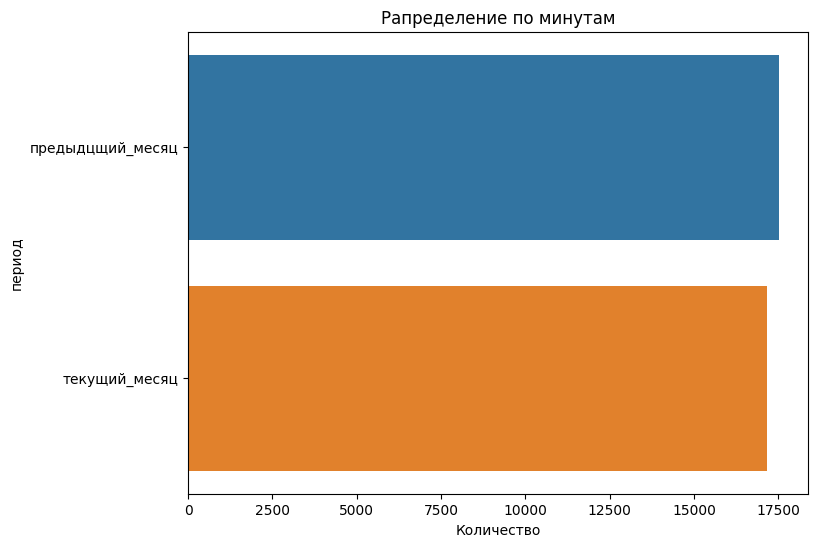

In [38]:
plt.figure(figsize=(8,6))
plot = sns.barplot(x='минут', data=market_time_by_period, y=market_time_by_period.index)
plot.set_title(f'Рапределение по минутам')
plot.set_xlabel('Количество')

Найдена опечатка, исправим ее.

In [39]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

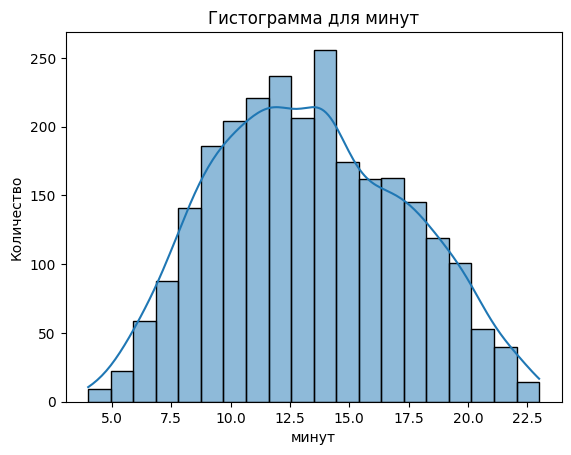

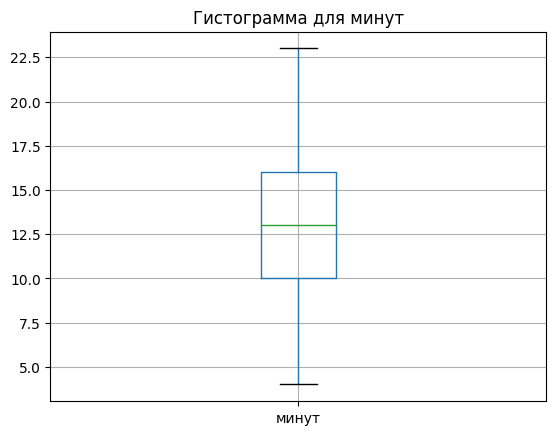

In [40]:
sns.histplot(data = market_time, x = 'минут', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Гистограмма для минут')
plt.show()

market_time.boxplot(column = 'минут')
plt.title('Гистограмма для минут')
plt.show()

Последняя таблица - **money**

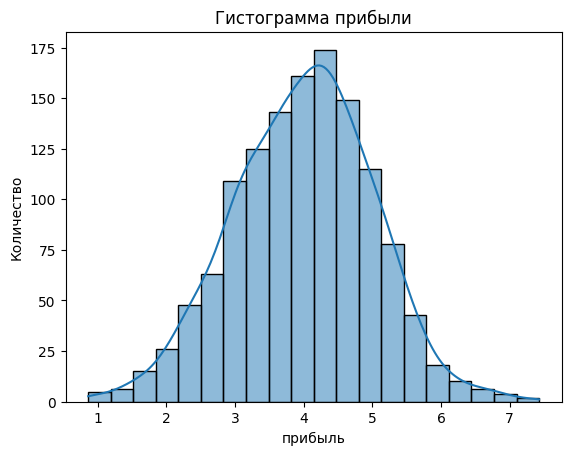

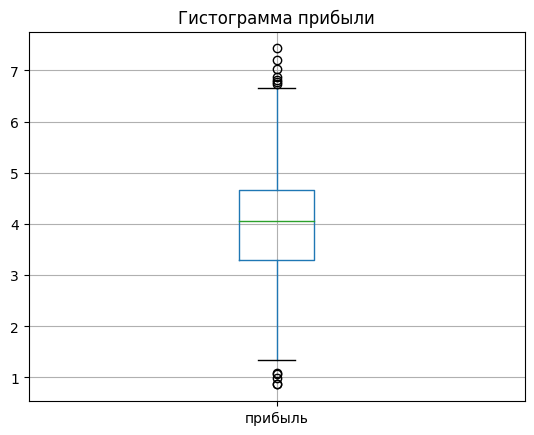

In [41]:
sns.histplot(data = money, x = 'прибыль', bins = 20, kde = True)
plt.ylabel('Количество')
plt.title('Гистограмма прибыли')
plt.show()

money.boxplot(column = 'прибыль')
plt.title('Гистограмма прибыли')
plt.show()

### Выбор активных пользователей

После анализа данных необходимо выбрать клиентов, которые проявляли активность в течение не менее трех месяцев. Это означает, что нам нужны записи из market_money, где клиент совершал покупки за все три периода: 'препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'.

In [42]:
agg_dict = {'период': ['count']}
grouped = market_money.groupby('id').agg(agg_dict)
grouped.columns = ['count']

grouped = grouped[grouped['count'] == 3]
market_file = market_file[market_file['id'].isin(grouped.index)]
len(market_file)

1296

Почти все записи удовлетворяют нашим условиям.

### Промежуточный вывод.

На данном этапе был выполнен анализ данных. В процессе работы были исправлены ошибки в данных, которые легко находились с помощью графиков. Также было обнаружено небольшое количество явно аномальных значений, которые были исключены из анализа. В целом, данные выглядят корректно. Дополнительно были оставлены только пользователи, совершившие покупки в течение последних трех месяцев.

## Объединение таблиц

Теперь объеденим данные из датафреймов `market_file`, `market_money`, `market_time` в одну таблицу.

In [43]:
market_money_grouped = market_money.pivot_table(index=['id'], columns = ["период"])
market_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_grouped['id'] = market_money_grouped.index

market_time_grouped = market_time.pivot_table(index = ['id'], columns = ["период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_grouped['id'] = market_time_grouped.index

market_full = market_file.join(market_money_grouped, on = 'id', lsuffix = "_left", rsuffix = "_выручка")
market_full = market_full.rename(columns = {'id_left':'id'})
market_full = market_full.join(market_time_grouped, on = 'id', lsuffix = "_left", rsuffix = "_минут")
market_full = market_full.rename(columns = {'id_left':'id'})
market_full.drop(['id_выручка', 'id_минут'], axis = 1, inplace = True)
market_full.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,Снизилась,премиум,да,4.4000,4,819,0.7500,Товары для детей,4,4,2,5,"5,216.0000","4,472.0000","4,971.6000",12,10
2,215350,Снизилась,стандарт,нет,4.9000,3,539,0.1400,Домашний текстиль,5,2,1,5,"5,457.5000","4,826.0000","5,058.4000",8,13
3,215351,Снизилась,стандарт,да,3.2000,5,896,0.9900,Товары для детей,5,0,6,4,"6,158.0000","4,793.0000","6,610.4000",11,13
4,215352,Снизилась,стандарт,нет,5.1000,3,1064,0.9400,Товары для детей,3,2,3,2,"5,807.5000","4,594.0000","5,872.5000",8,11
5,215353,Снизилась,стандарт,да,3.3000,4,762,0.2600,Домашний текстиль,4,1,1,4,"4,738.5000","5,124.0000","5,388.5000",10,10


## Корреляционный анализ

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


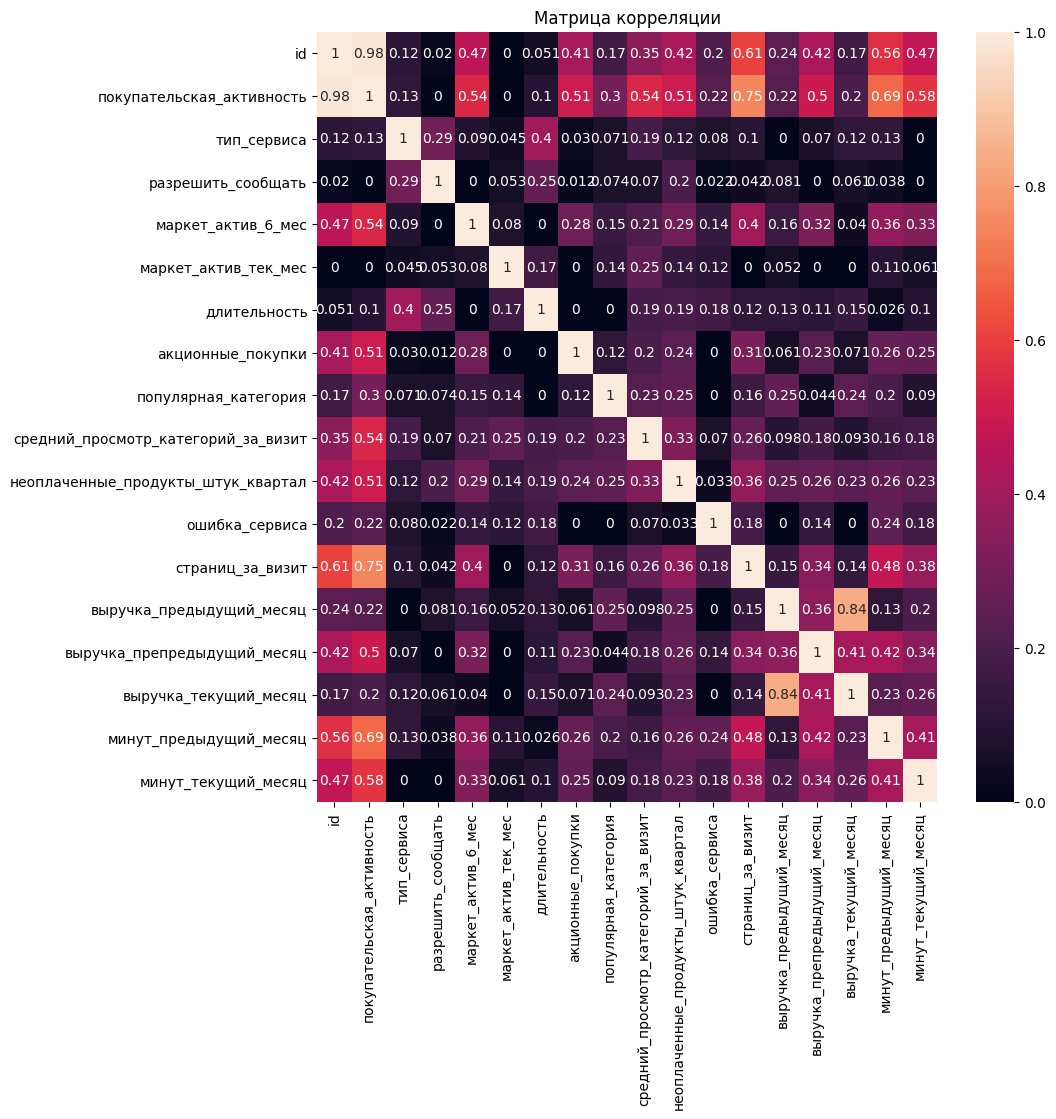

In [44]:
corr_matrix = market_full.phik_matrix()
plt.figure(figsize = (10, 10))
sns.heatmap(corr_matrix, annot = True)
plt.title('Матрица корреляции')
plt.show()

### Промежуточный вывод

Целевым показателем выступает Покупательская_активность. Среди полей, которые имеют с ним какую-либо корреляцию, можно выделить следующие: Маркет_актив_6_мес, Акционные_покупки, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал, Страниц_за_визит, Выручка_предыдущий_месяц, минут_предыдущий_месяц, минут_текущий_месяц. Наиболее значимая корреляция наблюдается между Покупательская_активность и парой показателей Выручка_предыдущий_месяц и Выручка_текущий_месяц, однако значение корреляции не достигает 0.9, поэтому эти признаки решено оставить.

Также на графике выявлена необычная корреляция между Покупательская_активность и id. Поскольку этот признак не представляет ценности для анализа, его следует удалить из датасета. Однако для дальнейшего использования id необходимо преобразовать в индекс датасета.

## Использование пайплайнов

Начнем с создания модели. Рассмотрим модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(), используя пайплайны. Сначала подготовим данные. Преобразуем целевой признак в значения 0 и 1. Также преобразуем колонку `Акционные_покупки` в категориальный признак.

In [45]:
market_full['покупательская_активность'] = market_full['покупательская_активность'].apply(lambda x: 1 if x == 'Снизилась' else 0 )
market_full['покупательская_активность'] = market_full['покупательская_активность'].astype(int)    

In [46]:
market_full['акционные_покупки_категория'] = market_full['акционные_покупки'].apply(lambda x: 'Часто покупает по акции' if x >= 0.5 else 'Редко покупает по акции' )
market_full = market_full.drop(['акционные_покупки'], axis = 1)

In [47]:
market_full = market_full.set_index('id')

In [48]:
market_full.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4000,4,819,Товары для детей,4,4,2,5,"5,216.0000","4,472.0000","4,971.6000",12,10,Часто покупает по акции
215350,1,стандарт,нет,4.9000,3,539,Домашний текстиль,5,2,1,5,"5,457.5000","4,826.0000","5,058.4000",8,13,Редко покупает по акции
215351,1,стандарт,да,3.2000,5,896,Товары для детей,5,0,6,4,"6,158.0000","4,793.0000","6,610.4000",11,13,Часто покупает по акции
215352,1,стандарт,нет,5.1000,3,1064,Товары для детей,3,2,3,2,"5,807.5000","4,594.0000","5,872.5000",8,11,Часто покупает по акции
215353,1,стандарт,да,3.3000,4,762,Домашний текстиль,4,1,1,4,"4,738.5000","5,124.0000","5,388.5000",10,10,Редко покупает по акции


In [49]:
X = market_full.drop(['покупательская_активность'], axis = 1)
y = market_full['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [50]:
X_train.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
id,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5000,4,510,Мелкая бытовая техника и электроника,2,4,7,16,"5,170.5000","4,347.0000","6,014.2000",20,6,Редко покупает по акции
215361,стандарт,да,5.1000,4,199,Техника для красоты и здоровья,4,5,2,3,"6,400.0000","4,597.0000","3,789.7000",11,13,Редко покупает по акции
215884,стандарт,да,4.3000,5,997,Мелкая бытовая техника и электроника,5,1,3,11,"4,113.0000","4,626.0000","3,798.4000",13,10,Редко покупает по акции
216564,стандарт,да,5.6000,4,342,Кухонная посуда,2,7,5,8,"4,930.0000","5,269.0000","4,766.2000",14,19,Часто покупает по акции
215715,премиум,да,3.6000,5,873,Товары для детей,3,2,2,5,"3,716.0000","4,691.0000","4,600.0000",10,10,Редко покупает по акции


In [51]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория', 'тип_сервиса']
ord_columns = ['акционные_покупки_категория']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'маркет_актив_тек_мес', 
               'длительность', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
               'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 
               'минут_предыдущий_месяц', 'минут_текущий_месяц']

In [52]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown = 'ignore', drop='first', sparse = False))
    ]
)

In [53]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories = [
                                      ['Редко покупает по акции','Часто покупает по акции']],
                          handle_unknown = 'use_encoded_value',
                          unknown_value = np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
        )
    ]
)

In [54]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder = 'passthrough'
)

In [55]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state = RANDOM_STATE))
])

In [67]:
param_grid = [

    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },


    {
        'models': [LogisticRegression(
            random_state = RANDOM_STATE, 
            solver = 'liblinear', 
            penalty = 'l1'
        )],
        'models__C': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    {
        'models': [SVC(random_state = RANDOM_STATE, kernel = 'poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [68]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv = 5,
    scoring = 'roc_auc',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

In [69]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория',
                                                                                'тип_сервиса']),
                                                                              ('ord',...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [70]:
print('Лучшая модель:', randomized_search.best_estimator_)
print ('Качество модели:', randomized_search.best_score_)

Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория',
                                                   'тип_сервиса']),
                                                

Модель показала отличный результат. Теперь проверим ее на тестовых данных.

In [60]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_test_proba[:,1]))

Метрика ROC-AUC на тестовой выборке: 0.8238077903167091


In [61]:
print('Метрика F1-score на тестовой выборке:', f1_score(y_test, y_test_pred))

Метрика F1-score на тестовой выборке: 0.7476635514018691


### Промежуточный вывод

На данном этапе исследования была разработана и обучена модель для выявления снижения активности пользователей сервиса. Наилучшие результаты продемонстрировала модель логистиеской регрессии. При оценке с помощью метрики roc_auc на тренировочной выборке был достигнут результат почти 0.9, на тестовой — 0.92.Стоит отметить, что метрика ROC-AUC была выбрана так как присутствует дисбаланс классов, а данная метрика отлично с этим справляется. Эти показатели свидетельствуют о высокой эффективности модели в предсказании активности пользователей. Дополнительно, метрика f1 достигла хорошего значения в 0.85, что также подтверждает её точность.

## Анализ важности признаков

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 

In [62]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_2 = pd.DataFrame(X_test_2, columns = feature_names)
 
shap_values = explainer(X_test_2)
 
display(shap.plots.bar(shap_values, max_display=30))

InvalidModelError: An unknown model type was passed: <class 'sklearn.tree._classes.DecisionTreeClassifier'>

In [ ]:
display(shap.plots.beeswarm(shap_values, max_display=15))

Пять ключевых признаков для модели: `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит`, `мин_предыдущий_месяц`, `мин_текущий_месяц`, `неоплаченный_продукты_штук_квартал`. Опираясь на свой опыт покупок на маркетплейсах, могу согласиться с таким выбором. Чем больше страниц пролистать, тем выше вероятность найти нужный товар. При поиске конкретного продукта часто добавляешь в корзину интересные находки, а в итоге покупаешь только один из них.

Менее значимыми признаками оказались: `Популярная категория` (кроме бытовой техники), `Маркет_актив_тек_мес`, `Разрешить сообщать`, `Тип_сервиса`, `Выручка_текущий_месяц`, `Длительность`, `Ошибка_сервиса`, `Выручка_предыдущий_месяц`.

Здесь я также могу согласиться с решениями модели. Мы рассматриваем только активных покупателей, поэтому дата регистрации и ошибки сервиса не так важны.

## Сегментация покупателей

Следующей целью исследования является выделение определенного сегмента пользователей и анализ их поведения. Это необходимо для разработки рекомендаций для заказчика по увеличению активности данного сегмента. 
Построим диграмму рассеяния Прибыли и Вероятности снижения активности пользователя, которую определила модель. 

In [ ]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]
X_test.head()

In [ ]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
df_full = pd.concat([X_train_full, X_test_full])

money = money.set_index('id')
df_full = df_full.join(money)
df_full.head()

In [ ]:
fig = plt.figure(figsize=(10,8))
sns.scatterplot(data = df_full, y = 'прибыль', x = 'вероятность_снижения')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от выручки')
plt.show()

Мы получили диаграмму, на которой показаны взаимосвязь прибыли и вероятность снижения активности покупателей. Однако я не вижу чёткой зависимости между этими показателями.

Давайте рассмотрим, как категориальные признаки распределяются на этой диаграмме.

In [ ]:
def build_scatterplots(cat_columns):
    for cat_col in cat_columns:
        fig = plt.figure(figsize = (10,8))
        sns.scatterplot(data = df_full, y = 'прибыль', x = 'вероятность_снижения', hue = cat_col)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title('Зависимость вероятности снижения активности от выручки')
        plt.show()

In [ ]:
cat_columns = list(df_full.select_dtypes(include = 'object').columns)
build_scatterplots(cat_columns)

В графиках особенно заметно распределение по категории "Акционные покупки". Пользователи, часто совершающие покупки по скидкам, имеют высокую вероятность снижения активности. Этот факт очевиден, так как скидки не действуют постоянно, и покупки в этом сегменте совершаются сезонно. Более того, пользователи, покупающие в основном по акциям, равномерно распределены по всему спектру прибыли.

Попробуем проанализировать этот сегмент. Для этого добавим колонку, где промаркируем пользователей, которые часто совершают покупки по акции и имеют вероятность снижения активности более 80%.

In [ ]:
df_full.head()

In [ ]:
df_full['сегмент'] = df_full.apply( lambda row: 'Исследуемый сегмент' \
        if row['вероятность_снижения'] > 0.8 and row['акционные_покупки_категория'] == 'Часто покупает по акции' \
        else 'Остальные пользователи', axis = 1)


In [ ]:
display(df_full['популярная_категория'].unique())    
plt.figure(figsize = (8,6))
plot = sns.countplot(y = 'популярная_категория', data = df_full)
plot.set_title('популярная_категория')
plot.set_xlabel('Количество')

Видим, что самая популярная категория - Товары для детей. Самая непопулярная - Кухонная посуда.

In [ ]:
display(df_full['тип_сервиса'].unique())    
plt.figure(figsize = (8,6))
plot = sns.countplot(y = 'тип_сервиса', data = df_full)
plot.set_title('тип_сервиса')
plot.set_xlabel('Количество')

Логично, что товары из категории премиум покупают реже, чем стандартные.

In [ ]:
plt.figure(figsize = (8,6))
plot = sns.histplot(df_full, bins = 20, kde = True, hue = 'сегмент', x = 'страниц_за_визит')
plot.set_title('Рапределение страниц_за_визит')
plot.set_ylabel('Количество')

Пользователи, приобретающие товары по скидке, просматривают меньшее количество страниц. Похоже, они не занимаются поиском и выбором, а совершают покупки целенаправленно.

In [ ]:
plt.figure(figsize = (8,6))
plot = sns.histplot(df_full, bins = 20, kde = True, hue = 'сегмент', x = 'средний_просмотр_категорий_за_визит')
plot.set_title('Рапределение средний_просмотр_категорий_за_визит')
plot.set_ylabel('Количество')

А в среднее кол-во просматриваемых категорий не различается.

In [ ]:
plt.figure(figsize = (8,6))
plot = sns.histplot(df_full, bins = 20, kde = True, hue = 'сегмент', x = 'неоплаченные_продукты_штук_квартал')
plot.set_title('Рапределение неоплаченные_продукты_штук_квартал')
plot.set_ylabel('Количество')

Выяснилось, что представители исследуемой группы в среднем оставляют в корзине больше товаров без оплаты.

Теперь сравним количество маркетинговых коммуникаций у покупателей по акции и всего массива пользователей. 

In [ ]:
plt.figure(figsize = (8,6))
plot = sns.histplot(df_full, bins = 20, kde = True, hue = 'сегмент', x = 'маркет_актив_6_мес')
plot.set_title('Рапределение маркет_актив_6_мес')
plot.set_ylabel('Количество')

In [ ]:
plt.figure(figsize = (8,6))
plot = sns.histplot(df_full, bins = 20, kde = True, hue = 'сегмент', x = 'маркет_актив_тек_мес')
plot.set_title('Рапределение маркет_актив_тек_мес')
plot.set_ylabel('Количество')

Клиенты, участвующие в акциях, получали такое же внимание от маркетплейса, как и все остальные пользователи. Это означает, что магазин не предоставляет им дополнительные способы получения информации о скидках. Вся информация либо содержится в письмах, которые получают все пользователи, либо размещена на главной странице сайта.

## Общий вывод

Целью данного исследования была разработка модели, способной прогнозировать снижение покупательской активности клиентов интернет-магазина "В один клик".

Еще одной задачей было изучение выбранного сегмента пользователей.

1.  Импорт данных

Исходными материалами для анализа послужили четыре отдельных CSV-файла:

- с данными о поведении покупателей на сайте, их взаимодействии и покупках.

- с информацией о выручке, полученной магазином от каждого покупателя за определённый период.

- с данными о времени (в минутах), которое покупатель проводил на сайте за выбранный период.

- сведения о среднемесячной прибыли от продаж каждому покупателю за последние три месяца.


2. Предобработка данных

Хотя исходные данные были хорошего качества, они требовали некоторой предварительной обработки перед анализом.

Во первых, было необходимо унифицировать названия признаков. Имена были оставлены на кириллице, но пробелы заменены на нижнее подчёркивание.

Во вторых, проверка на пропуски показала, что в данных их нет.

3. Исследование данных

На данном этапе были построены графики распределения всех признаков. Анализ графиков позволил выявить и исправить ошибки в категориальных признаках. Также было замечено, что график распределения признака `Акционные_покупки` демонстрирует два явно выраженных кластера пользователей. В результате этот признак был преобразован в категориальный.

4. Корреляционный анализ

Целевым признаком в исследовании является `Покупательская_активность`. Вот список признаков, которые имеют хотя бы некоторую корреляцию с целевым показателем: `Маркет_актив_6_мес`, `Акционные_покупки`, `Средний_просмотр_категорий_за_визит`, `Неоплаченные_продукты_штук_квартал`, `Страниц_за_визит`, `Выручка_препредыдущий_месяц`, `минут_предыдущий_месяц`, `минут_текущий_месяц`.

График также показал сильную зависимость между целевым признаком и идентификатором пользователя. В связи с этим при подготовке данных для обучения модели признак `id` был исключён.

Сильной корреляции между остальными признаками обнаружено не было, поэтому все они были оставлены в датасете.

5. Объединение таблиц

Датасеты `market_file`, `market_money` и `market_time` были объединены в один общий датафрейм.

6. Обучение моделей

С использованием пайплайнов из библиотеки sklearn были обучены следующие модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и `SVC()`. В процессе обучения моделей параметры гиперпараметров перебирались с целью нахождения оптимальной модели, обеспечивающей наилучший результат.

По итогам обучения наиболее эффективной оказалась модель Логистической регрессии. Метрика roc_auc для тренировочной выборки составила 0.9, для тестовой — 0.89. Интересно отметить, что значения метрики имеют довольно низкий разброс. Даже при наличии дисбаланса в целевом признаке удалось достичь значения метрики f1 = 0.9.

7. Анализ важности признаков

Наиболее значимыми оказались признаки, связанные с временем, проведённым покупателем на маркетплейсе. Наименее важными были категории товаров, которые интересовали пользователей, и коммуникации с ними.

Создаётся впечатление, что маркетинговые стратегии и рассылки не оказывают значительного влияния на активность покупателей. Ключевым фактором, способствующим увеличению продаж, является время, которое пользователи проводят на сайте.

8. Сегментация пользователей

Для анализа был выбран сегмент пользователей, часто совершающих покупки по скидке и имеющих высокую вероятность снижения покупательской активности. Для повышения активности этого сегмента предлагается таргетированная настройка главной страницы маркетплейса, а также более частое обновление информации о скидках. Пользователи предпочитают видеть все предложения в одном месте, избегая необходимости переходить по различным страницам.

## Советы для заказчика:

***Давайте проанализируем некоторых пользователей, которые предпочитают покупки со скидкой и имеют склонность к снижению покупательской активности. Эти пользователи отличаются тем, что не проводят много времени на сайте, не сравнивают товары и не ищут наилучший вариант. Они ограничиваются просмотром одного-двух товаров и сразу совершают покупку.***

Как же стимулировать таких пользователей к более частым покупкам и, соответственно, увеличению прибыли? Вот несколько предложений:

1. Сократить расходы на рассылки. Если пользователь не заинтересован в просмотре страниц с товарами, вряд ли он обратит внимание на рекламные материалы.
2. Сосредоточиться на главной странице сайта. Главная страница должна быть адаптирована под конкретного покупателя. Важно, чтобы информация о скидках регулярно обновлялась на главной странице. Это позволит пользователю быстро ознакомиться с предложениями и совершить покупку, не переходя на другие страницы.